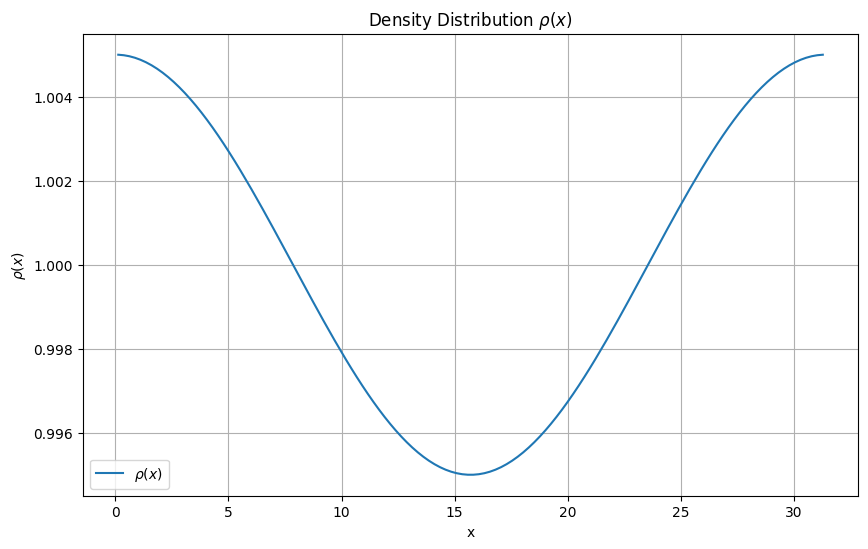

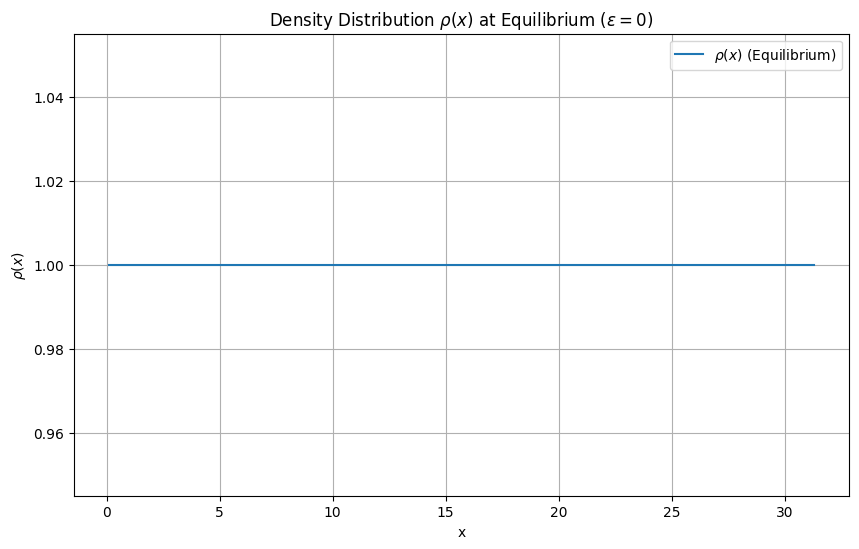

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq
import ot  # Python Optimal Transport (POT)

# Define the two-stream distribution with spatial dependence
def two_stream_distribution(x, v, v_bar, epsilon, beta):
    return (1 / (2 * np.sqrt(2 * np.pi))) * (
        np.exp(-(v - v_bar)**2 / 2) + np.exp(-(v + v_bar)**2 / 2)
    ) * (1 + epsilon * np.cos(beta * x))

# Generate particles with weight normalization for each x
def generate_particles_equilibrium_two_stream(f, N, L, v_max):
    """
    Generates N^2 particles uniformly distributed on the domain.
    Evaluates the function f(x, v) at the center of each small square.

    Parameters:
    f (function): Function of x and v, f(x,v)
    N (int): Number of grid points along each dimension (total N^2 particles)
    L (float): Length of the domain for x (domain [0, L])
    v_max (float): Maximum value for v (domain [-v_max, v_max])
    epsilon (float): Perturbation parameter for normalization
    beta (float): Spatial frequency for normalization

    Returns:
    particles (list): A list of particles, where each particle is represented as a tuple (x, v, weight)
    """

    # Define the step sizes for x and v
    dx = L / N
    dv = 2 * v_max / N

    # Create the particle list
    particles = []

    # Loop over each point in the x grid
    for i in range(N):
        x = (i + 0.5) * dx  # Center of the current x cell
        normalization_factor = dx  # Target sum for weights over v

        # Store the weights for this x over all velocities
        weights = []
        for j in range(N):
            v = -v_max + (j + 0.5) * dv  # Center of the current v cell
            weight = f(x, v) * dx * dv
            weights.append(weight)

        # Normalize weights for the current x to match the desired sum
        weight_sum = np.sum(weights)
        if weight_sum != 0:  # Avoid division by zero
            normalized_weights = [w * normalization_factor / weight_sum for w in weights]
        else:
            normalized_weights = weights  # If the sum is zero, no need to normalize

        # Append the particles with the normalized weights
        for j, v in enumerate(np.linspace(-v_max + 0.5 * dv, v_max - 0.5 * dv, N)):
            particles.append((x, v, normalized_weights[j]))

    return particles


# Generate particles with weight normalization for each x
def generate_particles_two_stream(f, N, L, v_max, epsilon, beta):
    """
    Generates N^2 particles uniformly distributed on the domain.
    Evaluates the function f(x, v) at the center of each small square.

    Parameters:
    f (function): Function of x and v, f(x,v)
    N (int): Number of grid points along each dimension (total N^2 particles)
    L (float): Length of the domain for x (domain [0, L])
    v_max (float): Maximum value for v (domain [-v_max, v_max])
    epsilon (float): Perturbation parameter for normalization
    beta (float): Spatial frequency for normalization

    Returns:
    particles (list): A list of particles, where each particle is represented as a tuple (x, v, weight)
    """

    # Define the step sizes for x and v
    dx = L / N
    dv = 2 * v_max / N

    # Create the particle list
    particles = []

    # Loop over each point in the x grid
    for i in range(N):
        x = (i + 0.5) * dx  # Center of the current x cell
        normalization_factor = (1 + epsilon * np.cos(beta * x)) * dx  # Target sum for weights over v

        # Store the weights for this x over all velocities
        weights = []
        for j in range(N):
            v = -v_max + (j + 0.5) * dv  # Center of the current v cell
            weight = f(x, v) * dx * dv
            weights.append(weight)

        # Normalize weights for the current x to match the desired sum
        weight_sum = np.sum(weights)
        if weight_sum != 0:  # Avoid division by zero
            normalized_weights = [w * normalization_factor / weight_sum for w in weights]
        else:
            normalized_weights = weights  # If the sum is zero, no need to normalize

        # Append the particles with the normalized weights
        for j, v in enumerate(np.linspace(-v_max + 0.5 * dv, v_max - 0.5 * dv, N)):
            particles.append((x, v, normalized_weights[j]))

    return particles


# Compute the density rho(x) from particles
def compute_density(particles, N, L):
    """
    Compute the density rho(x) based on the positions of particles.

    Parameters:
    particles (list): List of particles, where each particle is represented as a tuple (x, v, weight)
    N (int): Number of cells along the x dimension
    L (float): Length of the domain for x (domain [0, L])

    Returns:
    rho_x (numpy array): Density values rho(x) at the center of each cell in the spatial domain
    x_centers (numpy array): Positions of the cell centers
    """

    # Define the step size for x
    dx = L / N

    # Initialize rho(x) for each cell
    rho_x = np.zeros(N)

    # Loop over the particles and accumulate their weights in the corresponding cell
    for x, _, weight in particles:
        # Find the index of the cell where this particle falls
        cell_index = int(x // dx)  # Find which cell the particle belongs to
        rho_x[cell_index] += weight  # Add the particle's weight to the cell

    # Compute the x positions of the cell centers
    x_centers = (np.arange(N) + 0.5) * dx

    return x_centers, rho_x / dx

# Example usage
# Parameters
N = 128
L = 10.0 * np.pi
v_max = 8.0
v_bar = 2.4
epsilon = 0.005
beta = 0.2

# Generate particles using the two-stream distribution
particles = generate_particles_two_stream(lambda x, v: two_stream_distribution(x, v, v_bar, epsilon, beta), N, L, v_max, epsilon, beta)

# Set the parameters for the equilibrium two-stream distribution (epsilon = 0)
epsilon_eq = 0.0

# Generate particles for the equilibrium distribution
equilibrium_particles = generate_particles_equilibrium_two_stream(
    lambda x, v: two_stream_distribution(x, v, v_bar, epsilon_eq, beta),
    N, L, v_max
)

# Compute the density rho(x)
x_centers, rho_x = compute_density(particles, N, L)

# Plot the density rho(x)
plt.figure(figsize=(10, 6))
plt.plot(x_centers, rho_x, label=r'$\rho(x)$')
plt.title(r'Density Distribution $\rho(x)$')  # Fixed title with correct LaTeX syntax
plt.xlabel('x')
plt.ylabel(r'$\rho(x)$')
plt.grid(True)
plt.legend()
plt.show()

# Compute the density rho(x) for the equilibrium state
x_centers_eq, rho_x_eq = compute_density(equilibrium_particles, N, L)

# Plot the density rho(x) for the equilibrium state
plt.figure(figsize=(10, 6))
plt.plot(x_centers_eq, rho_x_eq, label=r'$\rho(x)$ (Equilibrium)')
plt.title(r'Density Distribution $\rho(x)$ at Equilibrium ($\epsilon=0$)')
plt.xlabel('x')
plt.ylabel(r'$\rho(x)$')
plt.grid(True)
plt.legend()
plt.show()

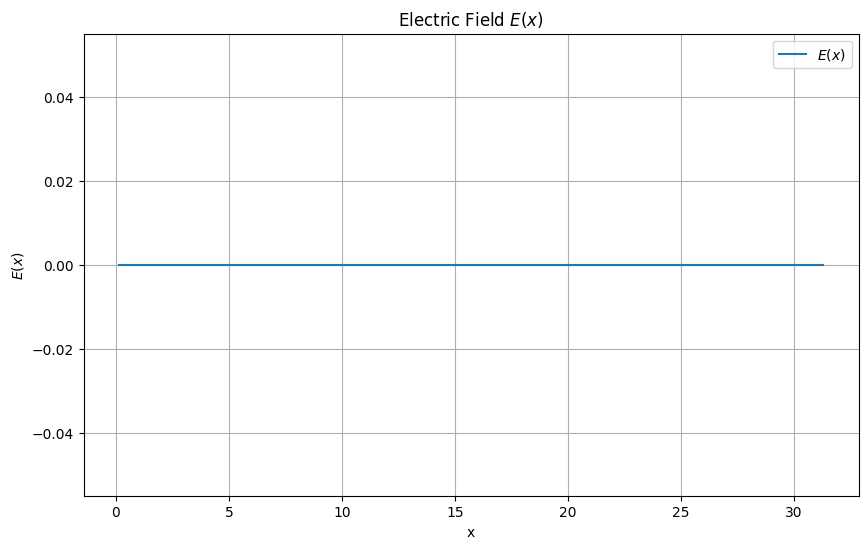

In [2]:
# Fourier solver to compute the electric field E(x)
def compute_electric_field(rho_x, N, L):
    """
    Compute the electric field E(x) from the charge density rho(x) using Fourier transforms.

    Parameters:
    rho_x (numpy array): The density values rho(x)
    N (int): Number of grid points
    L (float): Length of the domain for x (domain [0, L])

    Returns:
    E_x (numpy array): Electric field values E(x)
    """

    # Subtract background density 1 from rho to get charge density fluctuation
    delta_rho = rho_x - 1

    # Compute the Fourier transform of delta_rho
    delta_rho_k = fft(delta_rho)

    # Create the wave numbers for Fourier space
    k = fftfreq(N, d=L/N) * 2 * np.pi  # Frequencies in Fourier space

    # Avoid division by zero for k = 0
    k[0] = 1e-12

    # Solve for V(k) in Fourier space: V_k = delta_rho_k / (k^2)
    V_k = -delta_rho_k / (k**2)
    V_k[0] = 0  # Set the zero mode (constant) to 0 to avoid potential shift

    # Compute the electric field in Fourier space: E_k = -ik * V_k
    E_k = 1j * k * V_k

    # Inverse Fourier transform to get E(x) in real space
    E_x = np.real(ifft(E_k))

    return E_x


# # Example usage
# # Parameters
N = 128
L = 10.0 * np.pi
v_max = 6.0
v_bar = 2.4
epsilon = 0.0
beta = 0.2

# # Generate particles using the two-stream distribution
particles = generate_particles_two_stream(lambda x, v: two_stream_distribution(x, v, v_bar, epsilon, beta), N, L, v_max, epsilon, beta)

# # Compute the density rho(x)
x_centers, rho_x = compute_density(particles, N, L)

# # Compute the electric field E(x)
E_x = compute_electric_field(rho_x, N, L)

# # Plot the electric field E(x)
plt.figure(figsize=(10, 6))
plt.plot(x_centers, E_x, label=r'$E(x)$')
plt.title('Electric Field $E(x)$')
plt.xlabel('x')
plt.ylabel(r'$E(x)$')
plt.grid(True)
plt.legend()
plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot particles with color representing their weights
def plot_particles_at_step(particles, v_max, L, step):
    """
    Plot the particles with color representing their weights at a specific time step.

    Parameters:
    particles (list): List of particles (x, v, weight)
    v_max (float): Maximum velocity
    L (float): Length of the domain for x
    step (int): The current time step
    """
    x_vals = np.array([p[0] for p in particles])
    v_vals = np.array([p[1] for p in particles])
    weights = np.array([p[2] for p in particles])

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(x_vals, v_vals, c=weights, cmap='viridis', s=10)
    plt.colorbar(scatter, label='Weight')
    plt.xlim(0, L)
    plt.ylim(-v_max, v_max)
    plt.title(f'Particle Distribution at Step {step}')
    plt.xlabel('x')
    plt.ylabel('v')
    plt.show()

# Leapfrog integration method for N^2 particles in 1D, with periodic boundary conditions
def leapfrog_integration_particles_plots(particles, N, L, v_max, dt, num_steps, A=10):
    """
    Simulate the movement of particles using the Leapfrog integration scheme.

    Parameters:
    particles (list): List of particles (x, v, weight)
    N (int): Number of grid points
    L (float): Length of the domain
    dt (float): Time step
    num_steps (int): Number of time steps
    A (int): Interval to plot the particle distribution

    Returns:
    positions, velocities: Arrays of particle positions and velocities over time
    """
    positions = np.array([p[0] for p in particles])
    velocities = np.array([p[1] for p in particles])

    # pos_history = [positions.copy()]
    # vel_history = [velocities.copy()]

    for step in range(num_steps):
        # Half-step update of positions
        positions_half_step = positions + 0.5 * dt * velocities
        positions_half_step %= L

        # Compute the charge density rho(x)
        x_centers, rho_x = compute_density(particles, N, L)

        # Compute the electric field E(x) at the positions
        E_x = compute_electric_field(rho_x, N, L)

        # Interpolate E at particle positions
        indices = np.floor(positions_half_step / (L / N)).astype(int) % N
        E_at_positions = E_x[indices]

        # Full-step velocity update using the electric field
        velocities += dt * E_at_positions

        # Apply velocity clamping: restrict velocities to the range [-v_max, v_max]
        velocities = np.clip(velocities, -v_max, v_max)

        # Full-step position update
        positions = positions_half_step + 0.5 * dt * velocities

        # Apply periodic boundary conditions on positions
        positions = positions % L

        # Update particles with new positions and velocities
        for i in range(len(particles)):
            particles[i] = (positions[i], velocities[i], particles[i][2])

        # # Store positions and velocities
        # pos_history.append(positions.copy())
        # vel_history.append(velocities.copy())

        # Every A steps, plot the particle distribution
        if step % A == 0:
            plot_particles_at_step(particles, v_max, L, step)

    # return np.array(pos_history), np.array(vel_history)
    return particles

# # Example usage
# # Parameters
#dt = 0.1
#num_steps = 500  # Number of time steps to simulate

# # Generate particles using the two-stream distribution
#particles = generate_particles_two_stream(lambda x, v: two_stream_distribution(x, v, v_bar, epsilon, beta), N, L, v_max, epsilon, beta)

# # Simulate particle movement using Leapfrog integration and plot particles at intervals
#particles = leapfrog_integration_particles_plots(particles, N, L, v_max, dt, num_steps, A=10)


In [4]:
# Leapfrog integration method for N^2 particles in 1D, with periodic boundary conditions and external field
def leapfrog_integration_with_external_field(particles, N, L, v_max, dt, num_steps, H, A=10):
    """
    Simulate the movement of particles using the Leapfrog integration scheme with an external field H(x).

    Parameters:
    particles (list): List of particles (x, v, weight)
    N (int): Number of grid points
    L (float): Length of the domain
    dt (float): Time step
    num_steps (int): Number of time steps
    H (function): External field function H(x) that affects the velocities
    A (int): Interval to plot the particle distribution

    Returns:
    particles (list): Updated list of particles with positions, velocities, and weights
    """
    positions = np.array([p[0] for p in particles])
    velocities = np.array([p[1] for p in particles])

    # pos_history = [positions.copy()]
    # vel_history = [velocities.copy()]

    for step in range(num_steps):
        # Half-step update of positions
        positions_half_step = positions + 0.5 * dt * velocities
        positions_half_step %= L

        # Compute the charge density rho(x)
        x_centers, rho_x = compute_density(particles, N, L)

        # Compute the electric field E(x) at the positions
        E_x = compute_electric_field(rho_x, N, L)

        # Interpolate E at particle positions
        indices = np.floor(positions_half_step / (L / N)).astype(int) % N
        E_at_positions = E_x[indices]

        # Compute the external field H(x) at the particle positions
        H_at_positions = H(x_centers)[indices]

        # Full-step velocity update using the electric field and external field
        velocities += dt * (E_at_positions + H_at_positions)

        # Apply velocity clamping: restrict velocities to the range [-v_max, v_max]
        velocities = np.clip(velocities, -v_max, v_max)

        # Full-step position update
        positions = positions_half_step + 0.5 * dt * velocities

        # Apply periodic boundary conditions on positions
        positions = positions % L

        # Update particles with new positions and velocities
        for i in range(len(particles)):
            particles[i] = (positions[i], velocities[i], particles[i][2])

        # Every A steps, plot the particle distribution
        if step % A == 0:
            plot_particles_at_step(particles, v_max, L, step)

    return particles

# # Example usage
# # Parameters
# dt = 0.1
# num_steps = 500  # Number of time steps to simulate
# M = 0.03
# H = lambda x: M * np.cos(beta * x)  # External field function H(x)

# # Generate particles using the two-stream distribution
# particles = generate_particles_two_stream(lambda x, v: two_stream_distribution(x, v, v_bar, epsilon, beta), N, L, v_max, epsilon, beta)

# # Simulate particle movement using Leapfrog integration with external field and plot particles at intervals
# particles = leapfrog_integration_with_external_field(particles, N, L, v_max, dt, num_steps, H, A=10)

In [8]:
import seaborn as sns

# Compute the Sinkhorn Wasserstein distance and visualize the transport plan
def compute_wasserstein_distance_sinkhorn(particles1, particles2, L, reg=5e-2):
    positions1 = np.array([(p[0], p[1]) for p in particles1])
    weights1 = np.array([p[2] for p in particles1])

    positions2 = np.array([(p[0], p[1]) for p in particles2])
    weights2 = np.array([p[2] for p in particles2])

    # Ensure that the weights sum to the same total (normalize if necessary)
    weights1 /= np.sum(weights1)
    weights2 /= np.sum(weights2)

    # weights1 *= L
    # weights2 *= L

    # Compute the cost matrix based on the Euclidean distance in the (x, v) space
    cost_matrix = ot.dist(positions1, positions2, metric='euclidean')

    # Compute the Sinkhorn distance and the transport plan using the regularization parameter
    transport_plan = ot.sinkhorn(weights1, weights2, cost_matrix, reg, numItermax=5000)

    # Compute the Sinkhorn Wasserstein distance
    sinkhorn_dist = np.sum(transport_plan * cost_matrix)

    print(f"Sinkhorn Wasserstein distance: {sinkhorn_dist}")
    # print(f"Optimal transport plan (matrix):\n{transport_plan}")

    # # Visualize the transport plan as a heatmap
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(transport_plan, annot=False, cmap='Blues')
    # plt.title('Optimal Transport Plan (Sinkhorn)')
    # plt.xlabel('Distribution 2 (Target)')
    # plt.ylabel('Distribution 1 (Source)')
    # plt.show()

    # # Visualize the mapping between points in the two distributions
    # plt.figure(figsize=(10, 8))
    # plt.scatter(positions1[:, 0], positions1[:, 1], color='blue', label='Final State')
    # plt.scatter(positions2[:, 0], positions2[:, 1], color='red', label='Equilibrium Distribution')

    # # Plot the transport plan as lines between points
    # for i in range(len(particles1)):
    #     for j in range(len(particles2)):
    #         if transport_plan[i, j] > 1e-3:  # Only draw lines for significant mass transfer
    #             plt.plot([positions1[i, 0], positions2[j, 0]], [positions1[i, 1], positions2[j, 1]],
    #                      color='gray', alpha=0.5)

    # plt.title('Mapping of Optimal Transport Plan')
    # plt.legend()
    # plt.show()

    return sinkhorn_dist, transport_plan

In [9]:
from scipy.stats import gaussian_kde
from scipy import integrate


def get_kde(particles1, particles2):
    positions1 = np.array(np.array([np.array([p[0], p[1]]) for p in particles1])).T
    weights1 = np.array([p[2] for p in particles1])

    positions2 =  np.array(np.array([np.array([p[0], p[1]]) for p in particles2])).T
    weights2 = np.array([p[2] for p in particles2])

    # Ensure that the weights sum to the same total (normalize if necessary)
    weights1 /= np.sum(weights1)
    weights2 /= np.sum(weights2)

    kde1 = gaussian_kde(positions1, weights=weights1)
    kde2 = gaussian_kde(positions2, weights=weights2)

    return kde1, kde2


# Compute the L2 distance
def compute_l2_distance_particles(particles1, particles2, L, v_max):
    kde1, kde2 = get_kde(particles1, particles2)

    func_dist = lambda v, x: (kde1((x,v)) - kde2((x,v)))**2

    dist = integrate.dblquad(func_dist, 0, L, -v_max, v_max)[0]

    # print(f"Optimal transport plan (matrix):\n{transport_plan}")

    # # Visualize the transport plan as a heatmap
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(transport_plan, annot=False, cmap='Blues')
    # plt.title('Optimal Transport Plan (Sinkhorn)')
    # plt.xlabel('Distribution 2 (Target)')
    # plt.ylabel('Distribution 1 (Source)')
    # plt.show()

    # # Visualize the mapping between points in the two distributions
    # plt.figure(figsize=(10, 8))
    # plt.scatter(positions1[:, 0], positions1[:, 1], color='blue', label='Final State')
    # plt.scatter(positions2[:, 0], positions2[:, 1], color='red', label='Equilibrium Distribution')

    # # Plot the transport plan as lines between points
    # for i in range(len(particles1)):
    #     for j in range(len(particles2)):
    #         if transport_plan[i, j] > 1e-3:  # Only draw lines for significant mass transfer
    #             plt.plot([positions1[i, 0], positions2[j, 0]], [positions1[i, 1], positions2[j, 1]],
    #                      color='gray', alpha=0.5)

    # plt.title('Mapping of Optimal Transport Plan')
    # plt.legend()
    # plt.show()
    return dist


In [10]:
# Leapfrog integration method for N^2 particles in 1D, with periodic boundary conditions and external field
def leapfrog_integration_with_external_field_computation_only(particles, N, L, v_max, dt, num_steps, H):
    """
    Simulate the movement of particles using the Leapfrog integration scheme with an external field H(x).

    Parameters:
    particles (list): List of particles (x, v, weight)
    N (int): Number of grid points
    L (float): Length of the domain
    dt (float): Time step
    num_steps (int): Number of time steps
    H (function): External field function H(x) that affects the velocities
    A (int): Interval to plot the particle distribution

    Returns:
    particles (list): Updated list of particles with positions, velocities, and weights
    """
    positions = np.array([p[0] for p in particles])
    velocities = np.array([p[1] for p in particles])

    # pos_history = [positions.copy()]
    # vel_history = [velocities.copy()]

    for step in range(num_steps):
        # Half-step update of positions
        positions_half_step = positions + 0.5 * dt * velocities
        positions_half_step %= L

        # Compute the charge density rho(x)
        x_centers, rho_x = compute_density(particles, N, L)

        # Compute the electric field E(x) at the positions
        E_x = compute_electric_field(rho_x, N, L)

        # Interpolate E at particle positions
        indices = np.floor(positions_half_step / (L / N)).astype(int) % N
        E_at_positions = E_x[indices]

        # Compute the external field H(x) at the particle positions
        H_at_positions = H(x_centers)[indices]

        # Full-step velocity update using the electric field and external field
        velocities += dt * (E_at_positions + H_at_positions)

        # Apply velocity clamping: restrict velocities to the range [-v_max, v_max]
        velocities = np.clip(velocities, -v_max, v_max)

        # Full-step position update
        positions = positions_half_step + 0.5 * dt * velocities

        # Apply periodic boundary conditions on positions
        positions = positions % L

        # Update particles with new positions and velocities
        for i in range(len(particles)):
            particles[i] = (positions[i], velocities[i], particles[i][2])

        # # Every A steps, plot the particle distribution
        # if step % A == 0:
        #     plot_particles_at_step(particles, v_max, L, step)

    return particles

# Perform landscape search over a1 in H(x) = a1 * cos(beta * x)
def landscape_search_1d(particles, equilibrium_particles, N, L, v_max, dt, num_steps, beta, reg=5e-1, obj="L^2", plot=False):
    """
    Perform a landscape search for a1 in H(x) = a1 * cos(beta * x) and compute the Wasserstein distance.

    Parameters:
    particles (list): Initial list of particles (x, v, weight) for the two-stream distribution
    equilibrium_particles (list): List of equilibrium particles for comparison
    N (int): Number of grid points
    L (float): Length of the domain
    v_max (float): Maximum velocity
    dt (float): Time step
    num_steps (int): Number of time steps
    beta (float): Spatial frequency for external field H(x)
    reg (float): Regularization parameter for the Sinkhorn algorithm
    obj (str): objective function's landscape
    plot (bool): plotting at every step

    Returns:
    a1_vals (list): List of a1 values used for the external field
    wasserstein_dists (list): Corresponding Wasserstein distances for each a1
    """

    a1_vals = np.arange(-0.040, 0.045, 0.005)
    dists = []  # List to store Wasserstein distances

    for a1 in a1_vals:
        print(f"Running simulation for a1 = {a1:.3f}")

        # Define the external field H(x) for the current a1
        H = lambda x: a1 * np.cos(0.5 * x)

        # Reset the initial particles (so we start from the same initial condition)
        current_particles = generate_particles_two_stream(
            lambda x, v: two_stream_distribution(x, v, v_bar, epsilon, beta), N, L, v_max, epsilon, beta
        )

        # Run the Leapfrog integration with the external field
        final_particles = leapfrog_integration_with_external_field_computation_only(current_particles, N, L, v_max, dt, num_steps, H)

        if obj == "Wasserstein":
            # Compute the Wasserstein distance between final_particles and equilibrium_particles
            wasserstein_dist_sinkhorn, _ = compute_wasserstein_distance_sinkhorn(final_particles, equilibrium_particles, L, reg)

            # Store the Wasserstein distance for the current value of a1
            dists.append(wasserstein_dist_sinkhorn)

            title = "Wasserstein Distance"

        elif obj == "L^2":
            # Compute the L2 distance between final_particles and equilibrium_particles
            l2_distance = compute_l2_distance_particles(final_particles, equilibrium_particles, L, v_max) 
            
            # Store the L2 distance for the current value of a1
            dists.append(l2_distance)
            title = "L2 Distance"

        if plot:
        # Plot the final particle distribution for the current value of a1
            plot_particles_at_step(final_particles, v_max, L, num_steps)

    # After all iterations, plot the relation between a1 and Wasserstein distance
    plt.figure(figsize=(8, 6))
    plt.plot(a1_vals, dists, marker='o', color='b', label=title)
    plt.title('{} vs. a1'.format(title))
    plt.xlabel('$a_1$')
    plt.ylabel(title)
    plt.grid(True)
    plt.legend()
    plt.show()

    return a1_vals, dists


Running simulation for a1 = -0.040


/Users/martinguerra/.local/share/virtualenvs/Vlasov-Poisson-W2-xHkQinkr/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


Sinkhorn Wasserstein distance: 0.36069293698239996
Running simulation for a1 = -0.035
Sinkhorn Wasserstein distance: 0.3568381364371107
Running simulation for a1 = -0.030
Sinkhorn Wasserstein distance: 0.3445461199217845
Running simulation for a1 = -0.025
Sinkhorn Wasserstein distance: 0.32789793785705384
Running simulation for a1 = -0.020
Sinkhorn Wasserstein distance: 0.30385594633270735
Running simulation for a1 = -0.015
Sinkhorn Wasserstein distance: 0.2703211393828994
Running simulation for a1 = -0.010
Sinkhorn Wasserstein distance: 0.22478570949148471
Running simulation for a1 = -0.005
Sinkhorn Wasserstein distance: 0.1609465603936024
Running simulation for a1 = -0.000
Sinkhorn Wasserstein distance: 0.10789525431345466
Running simulation for a1 = 0.005
Sinkhorn Wasserstein distance: 0.16274124841875293
Running simulation for a1 = 0.010
Sinkhorn Wasserstein distance: 0.23809351208758847
Running simulation for a1 = 0.015
Sinkhorn Wasserstein distance: 0.29997727000312824
Running si

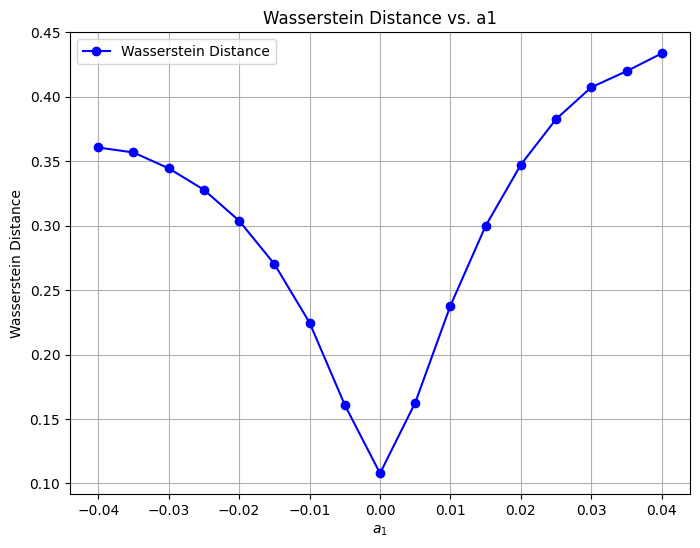

Running simulation for a1 = -0.040
Running simulation for a1 = -0.035
Running simulation for a1 = -0.030
Running simulation for a1 = -0.025
Running simulation for a1 = -0.020
Running simulation for a1 = -0.015
Running simulation for a1 = -0.010
Running simulation for a1 = -0.005
Running simulation for a1 = -0.000
Running simulation for a1 = 0.005
Running simulation for a1 = 0.010
Running simulation for a1 = 0.015
Running simulation for a1 = 0.020
Running simulation for a1 = 0.025
Running simulation for a1 = 0.030
Running simulation for a1 = 0.035
Running simulation for a1 = 0.040


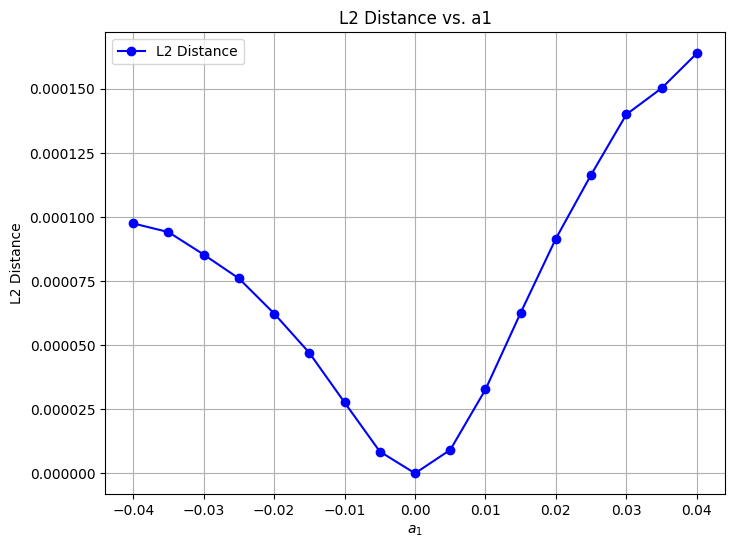

In [11]:
# Example usage
# Parameters
dt = 0.1
num_steps = 200  # Number of time steps to simulate
reg = 5e-2  # Regularization parameter for Sinkhorn

# Generate equilibrium particles for the comparison
equilibrium_particles = generate_particles_equilibrium_two_stream(
    lambda x, v: two_stream_distribution(x, v, v_bar, 0, beta), N, L, v_max
)

# Perform landscape search over a1 and plot the results
a1_vals, wasserstein_dists = landscape_search_1d(particles, equilibrium_particles, N, L, v_max, dt, num_steps, beta, reg, obj="Wasserstein")

a1_vals, l2_dists = landscape_search_1d(particles, equilibrium_particles, N, L, v_max, dt, num_steps, beta, reg, obj="L^2")

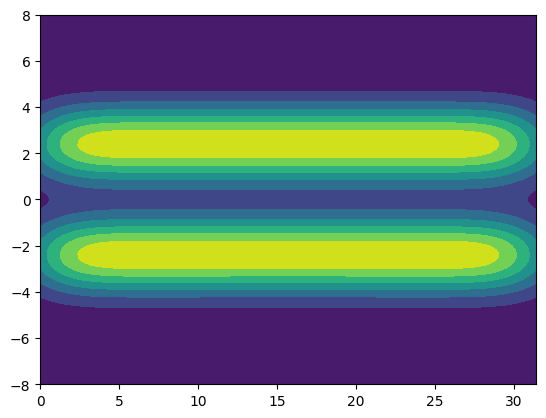

In [58]:
kde1, kde2 = get_kde(particles, equilibrium_particles)

x = np.linspace(0,L,100)
v = np.linspace(-v_max,v_max,100)
x_, v_ = np.meshgrid(x,v)
positions = np.vstack([x_.ravel(), v_.ravel()])

f = np.reshape(kde1(positions).T, x_.shape)

plt.contourf(x_,v_,f)
plt.show()


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Perform 2D landscape search over a1 and a2 in H(x) = a1 * sin(beta * x) + a2 * cos(beta * x)
def landscape_search_2d_sin_cos(particles, equilibrium_particles, N, L, v_max, dt, num_steps, beta, reg=5e-1):
    """
    Perform a landscape search for a1 and a2 in H(x) = a1 * sin(beta * x) + a2 * cos(beta * x)
    and compute the Wasserstein distance.

    Parameters:
    particles (list): Initial list of particles (x, v, weight) for the two-stream distribution
    equilibrium_particles (list): List of equilibrium particles for comparison
    N (int): Number of grid points
    L (float): Length of the domain
    v_max (float): Maximum velocity
    dt (float): Time step
    num_steps (int): Number of time steps
    beta (float): Spatial frequency for external field H(x)
    reg (float): Regularization parameter for the Sinkhorn algorithm

    Returns:
    a1_vals (list): List of a1 values used for the external field
    a2_vals (list): List of a2 values used for the external field
    wasserstein_dists (2D array): Corresponding Wasserstein distances for each (a1, a2) pair
    """

    a1_vals = np.arange(-0.05, 0.06, 0.01)  # Values of a1 from -0.1 to 0.1
    a2_vals = np.arange(-0.1, 0.11, 0.01)  # Values of a2 from -0.1 to 0.1
    wasserstein_dists = np.zeros((len(a1_vals), len(a2_vals)))  # 2D array to store Wasserstein distances

    for i, a1 in enumerate(a1_vals):
        for j, a2 in enumerate(a2_vals):
            print(f"Running simulation for a1 = {a1:.2f}, a2 = {a2:.2f}")

            # Define the external field H(x) for the current (a1, a2)
            H = lambda x: a1 * np.sin(beta * x) + a2 * np.cos(beta * x)

            # Reset the initial particles (so we start from the same initial condition)
            current_particles = generate_particles_two_stream(
                lambda x, v: two_stream_distribution(x, v, v_bar, epsilon, beta), N, L, v_max, epsilon, beta
            )

            # Run the Leapfrog integration with the external field
            final_particles = leapfrog_integration_with_external_field_computation_only(current_particles, N, L, v_max, dt, num_steps, H)

            # Compute the Wasserstein distance between final_particles and equilibrium_particles
            wasserstein_dist_sinkhorn, _ = compute_wasserstein_distance_sinkhorn(final_particles, equilibrium_particles, L, reg)

            # Store the Wasserstein distance for the current (a1, a2) combination
            wasserstein_dists[i, j] = wasserstein_dist_sinkhorn

    # Plot the 2D landscape using a heatmap
    plt.figure(figsize=(10, 8))
    plt.contourf(a1_vals, a2_vals, wasserstein_dists, levels=50, cmap='viridis')
    plt.colorbar(label='Wasserstein Distance')
    plt.title(r'Wasserstein Distance Landscape: $H(x) = a_1 \sin(\beta x) + a_2 \cos(\beta x)$')
    plt.xlabel('$a_1$')
    plt.ylabel('$a_2$')
    plt.grid(True)
    plt.show()

    return a1_vals, a2_vals, wasserstein_dists

# Example usage
# Parameters
dt = 0.1
num_steps = 400  # Number of time steps to simulate
reg = 5e-2  # Regularization parameter for Sinkhorn

# Generate equilibrium particles for the comparison
equilibrium_particles = generate_particles_equilibrium_two_stream(
    lambda x, v: two_stream_distribution(x, v, v_bar, 0, beta), N, L, v_max
)

# Perform landscape search over a1 and a2 and plot the results
a1_vals, a2_vals, wasserstein_dists = landscape_search_2d_sin_cos(particles, equilibrium_particles, N, L, v_max, dt, num_steps, beta, reg)


Running simulation for a1 = -0.05, a2 = -0.10


KeyboardInterrupt: 